### 2018/2019 - Task List 6

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)


1. Reimplement Task List 4 using automatic guide building, remember about code fixes (`with pyro.plate...`)
2. Visualize infered and given distributions
3. Explore hyperparameters in Task List 5
 - change learning rate
 - plot changes of loss for different learning rates
 - use different optimizers (at least two) ajd explore their parameters 
4. What will happen if you will set extremally low prior distribution parameters (`0.000000001`, mean, std)


## Required imports

In [31]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

from pyro.optim import Adam
from scipy.stats import norm

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

# Task List 4 reimplementation

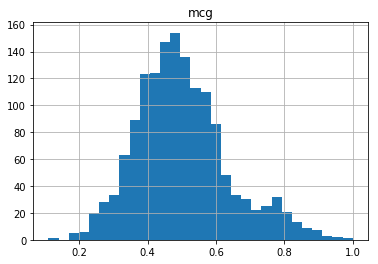

In [3]:
yeast = pd.read_csv('yeast.csv', header=None)
yeast.columns = ["seq_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "class"]

# column to use - mcg
yeast.hist(column='mcg', bins=30)
data = torch.tensor(yeast.mcg)

In [6]:
# Asume that you have some prior knowledge about parameters of that distribution
prior_mean = 0.2
real_std = data.std().detach().numpy()
print("prior mean: ", prior_mean)
print("real mean: ", data.mean())
print("real std: ", real_std)

prior mean:  0.2
real mean:  tensor(0.5001)
real std:  0.1372993


In [7]:
noise_std=0.2
def model(data):  # equivalent to conditioned_scale above
    prior=pyro.distributions.Normal(prior_mean, 1.)
    weight = pyro.sample("weight", prior)
    with pyro.plate("map", len(data)):
        pyro.sample("measurement", pyro.distributions.Normal(weight, noise_std), obs=data)
        
guide = AutoDiagonalNormal(model)
optim = Adam({"lr": 0.0003})
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

In [8]:
pyro.clear_param_store()
losses, mean  = [], []
num_steps = 12000
for t in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    param = pyro.param("auto_loc").double()
    mean.append(param)

100%|███████████████████████████████████| 12000/12000 [00:43<00:00, 274.13it/s]


auto scale =  tensor([0.2147], grad_fn=<AddBackward0>)
auto loc =  tensor([0.4992], requires_grad=True)


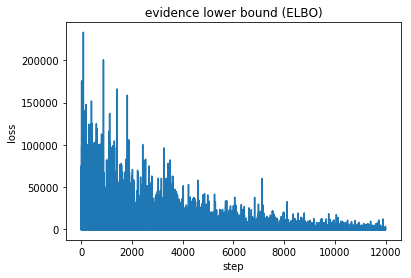

In [9]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")
print('auto scale = ',pyro.param("auto_scale"))
print('auto loc = ',pyro.param("auto_loc"))

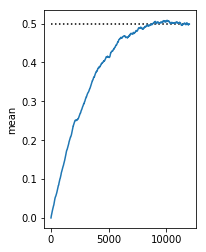

In [10]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[data.mean(),data.mean()], 'k:')
plt.plot(mean)
plt.ylabel('mean');

## Visualization of infered and given distribution

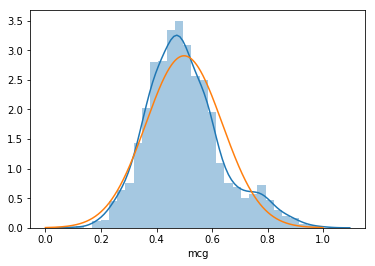

In [11]:
#yeast.hist(column='mcg', bins=30)
sns.distplot(yeast.mcg)

# Plot between 0 and 1 with .001 steps.
x_axis = np.arange(0, 1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,pyro.param("auto_loc").detach().numpy(),real_std))
plt.show()

# Task List 5 exploration

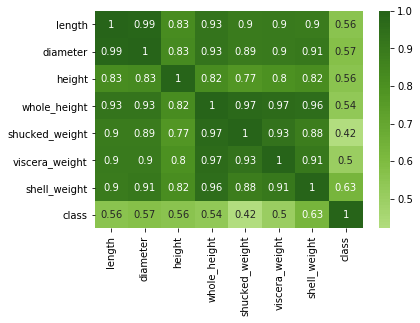

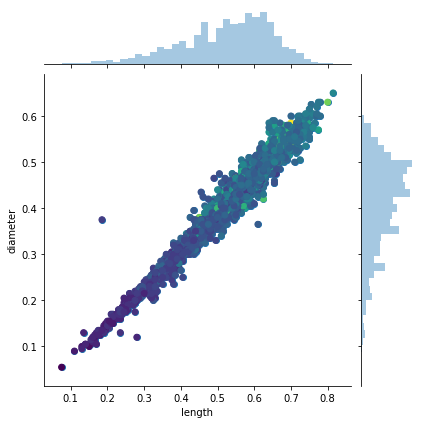

In [22]:
def correlation(data):
    corr = data.corr()
    sns.heatmap(corr, cmap="PiYG",
            annot=True, center=0)
    
def scatter_one_pair(data, attr1, attr2):
    if type(data[attr1][0]) is not str and type(data[attr2][0]) is not str:
        if type(data['class'][0]) is not str:
            g = sns.jointplot(x=attr1, y=attr2, data=data)
            g.ax_joint.scatter(x=attr1,y=attr2, data=data, c=data['class'])
        else:
            g = sns.jointplot(x=attr1, y=attr2, data=data)

abalone = pd.read_csv('abalone.csv', header=None)
abalone.columns = ["sex", "length", "diameter", "height", "whole_height", "shucked_weight", "viscera_weight", "shell_weight", "class"]

correlation(abalone)
scatter_one_pair(abalone, "length", "diameter")

x = torch.tensor(abalone.length)
y = torch.tensor(abalone.diameter)

x_data=x[:,None]
y_data=y[:,None]
count = x.numel()

### Model

In [23]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x)

In [27]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        w_prior = weight_prior
        b_prior = bias_prior
        f_prior = factor_prior
        priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 10.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model

def train():
    pyro.clear_param_store()
    num_iterations=6000
    model = create_probabilistic_model()
    guide = AutoDiagonalNormal(model)
    optim = optimizer
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_data, y_data.squeeze(-1))
        losses.append(loss)
        t.set_postfix(loss=loss)
    return (model, svi)

In [28]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))

## Plot changes of loss for different learning rates

auto_loc tensor([-6.4028,  0.4012,  0.4183, -0.0178], requires_grad=True)
auto_scale tensor([0.0858, 0.0014, 0.0021, 0.0013], grad_fn=<AddBackward0>)
Wall time: 2min 55s


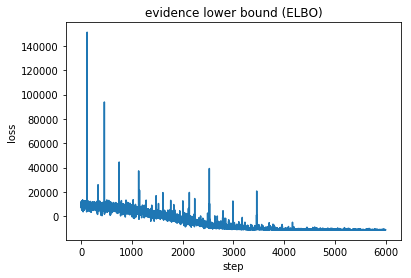

In [80]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

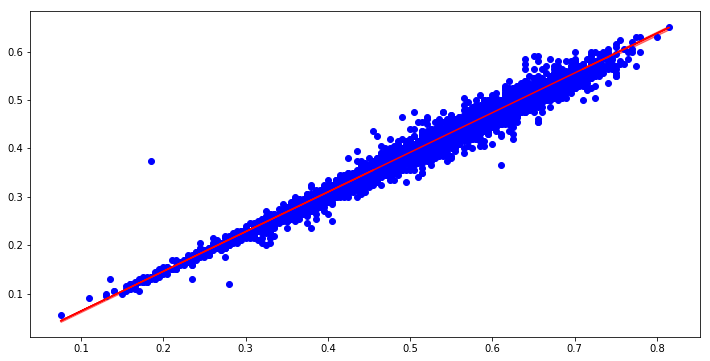

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

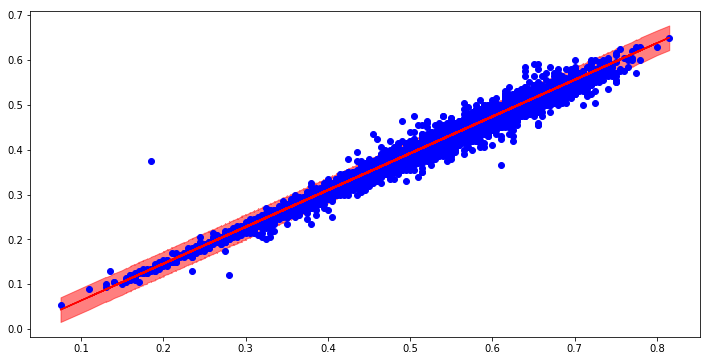

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-2.4900,  0.2217,  0.2299,  0.1713], requires_grad=True)
auto_scale tensor([0.6172, 0.3301, 0.3455, 0.2245], grad_fn=<AddBackward0>)
Wall time: 2min 57s


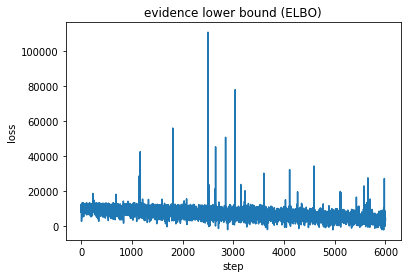

In [83]:
%%time
learning_rate = 0.001
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

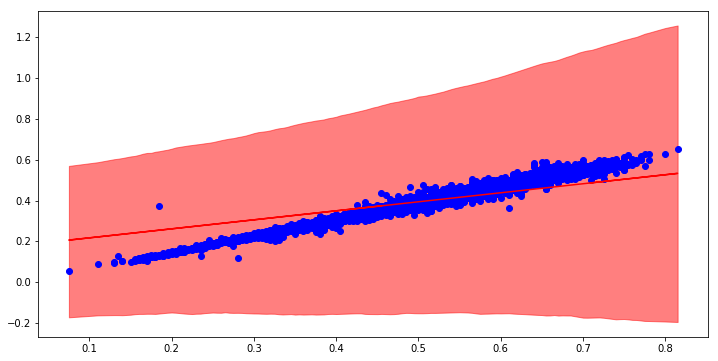

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

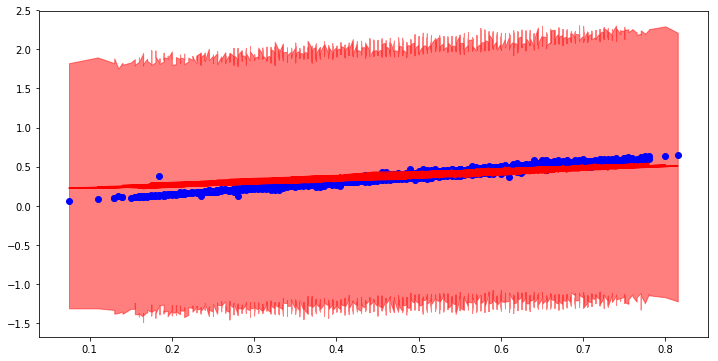

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-0.2413,  0.0590,  0.0607,  0.0570], requires_grad=True)
auto_scale tensor([0.9823, 0.9140, 0.9250, 0.8871], grad_fn=<AddBackward0>)
Wall time: 3min 8s


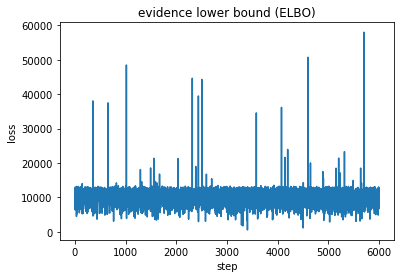

In [86]:
%%time
learning_rate = 0.0001
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

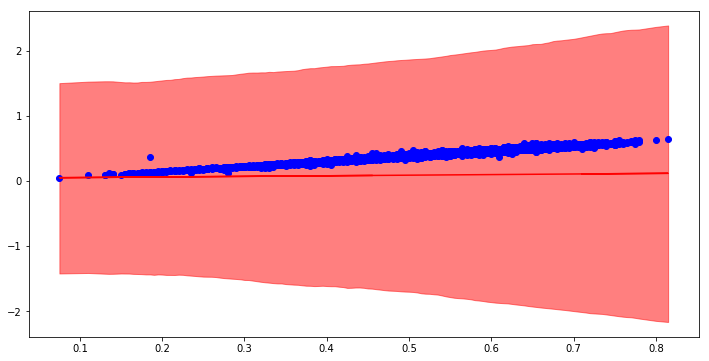

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

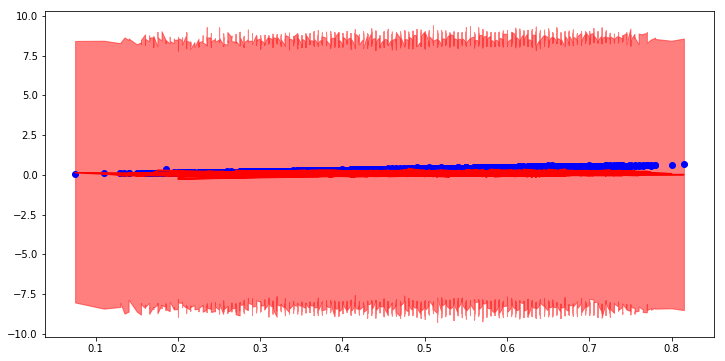

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-6.3505,  0.3831,  0.4387, -0.0163], requires_grad=True)
auto_scale tensor([0.0101, 0.0003, 0.0010, 0.0003], grad_fn=<AddBackward0>)
Wall time: 2min 55s


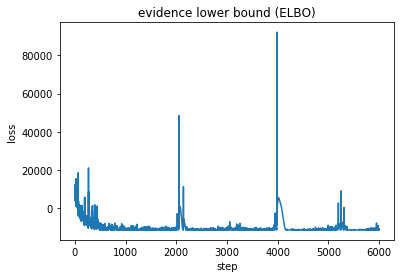

In [89]:
%%time
learning_rate = 0.1
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

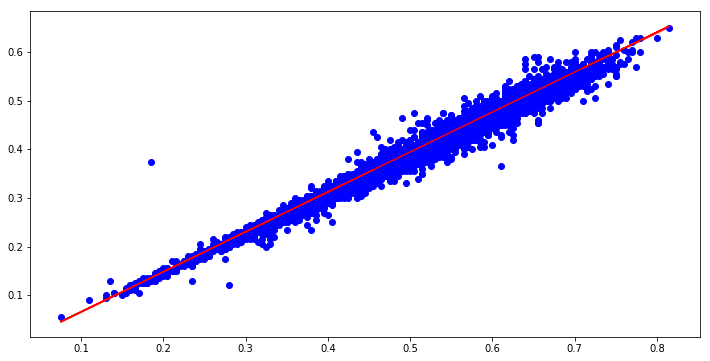

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

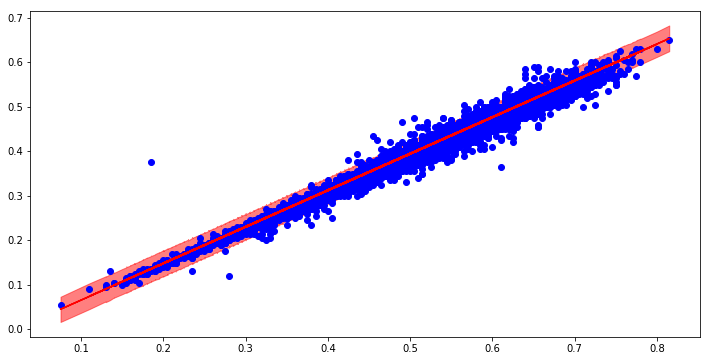

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-5.5161,  0.3835,  0.4382, -0.0162], requires_grad=True)
auto_scale tensor([8.3791e-03, 1.0270e-04, 3.2209e-04, 9.2695e-05],
       grad_fn=<AddBackward0>)
Wall time: 3min 1s


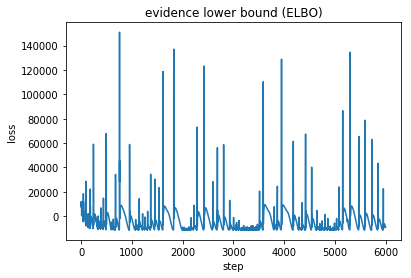

In [92]:
%%time
learning_rate = 0.2
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

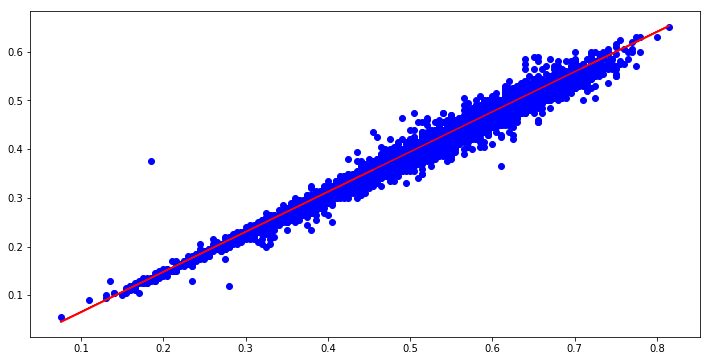

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

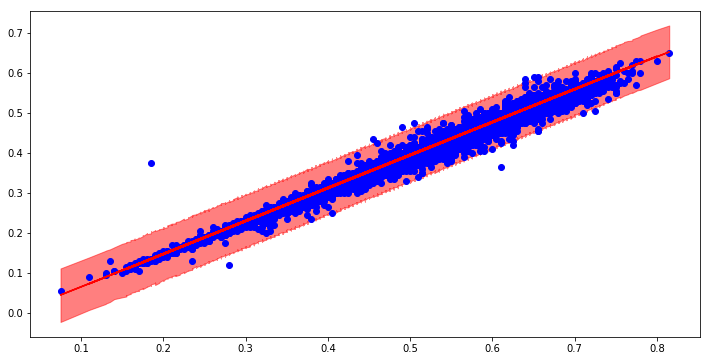

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

## use different optimizers (at least two) and explore their parameters

### Adadelta
* rho (float, optional) – coefficient used for computing a running average of squared gradients (default: 0.9)
* eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-6)
* lr (float, optional) – coefficient that scale delta before it is applied to the parameters (default: 1.0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)

auto_loc tensor([-0.1187,  0.0144,  0.0150,  0.0140], requires_grad=True)
auto_scale tensor([1.0081, 0.9836, 0.9843, 0.9737], grad_fn=<AddBackward0>)
Wall time: 3min 1s


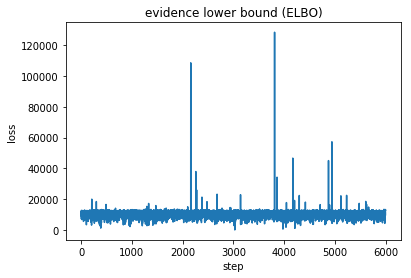

In [95]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adadelta({"lr": learning_rate, "rho": 0.9, "eps": 1e-6, "weight_decay": 0})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

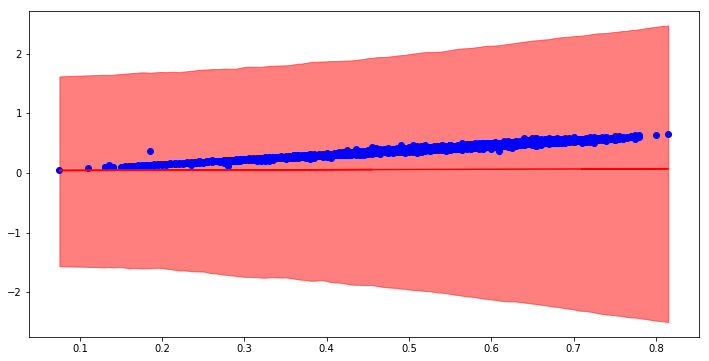

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

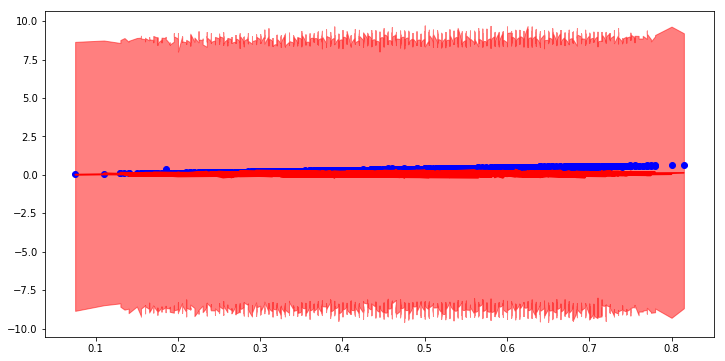

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-1.1514,  0.1150,  0.1209,  0.1097], requires_grad=True)
auto_scale tensor([0.9147, 0.8387, 0.8367, 0.7445], grad_fn=<AddBackward0>)
Wall time: 3min 2s


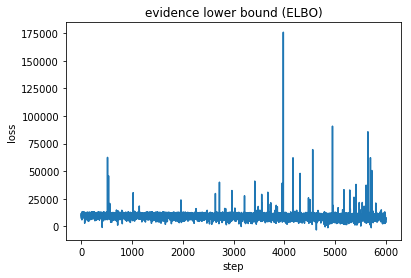

In [98]:
%%time
learning_rate = 0.1
optimizer = pyro.optim.Adadelta({"lr": learning_rate, "rho": 0.5, "eps": 1e-6, "weight_decay": 0})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

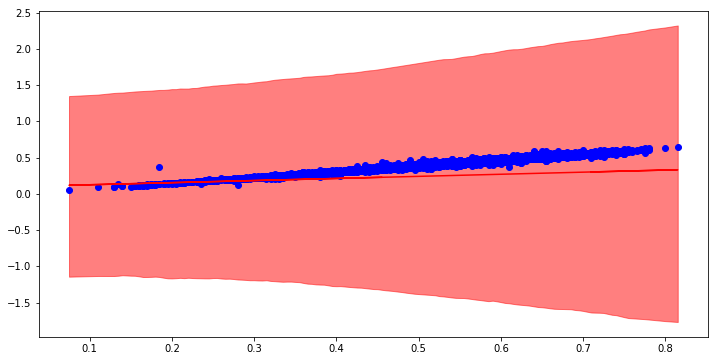

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

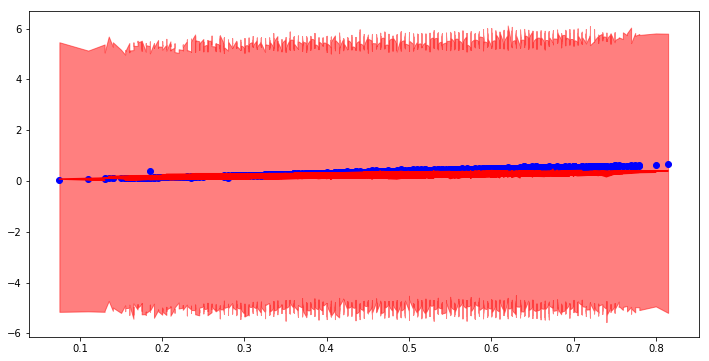

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

### Rprop
Implements the resilient backpropagation algorithm.

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float, optional) – learning rate (default: 1e-2)
* etas (Tuple[float, float], optional) – pair of (etaminus, etaplis), that are multiplicative increase and decrease factors (default: (0.5, 1.2))
* step_sizes (Tuple[float, float], optional) – a pair of minimal and maximal allowed step sizes (default: (1e-6, 50))

auto_loc tensor([-2.5693,  0.0768,  0.0768,  0.0766], requires_grad=True)
auto_scale tensor([0.9074, 0.9144, 0.9135, 0.4688], grad_fn=<AddBackward0>)
Wall time: 3min 6s


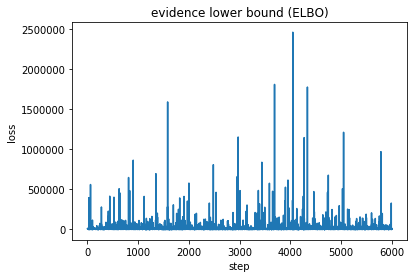

In [101]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Rprop({"lr": learning_rate, "etas": (0.5, 1.2), "step_sizes": (1e-6, 50)})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

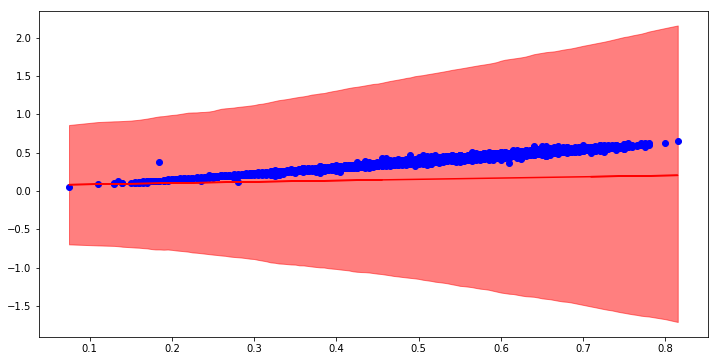

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

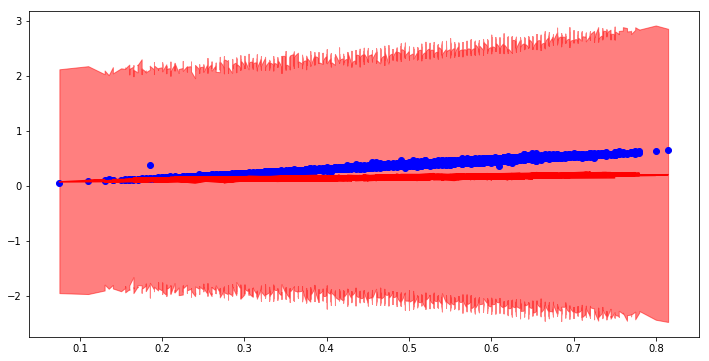

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-6.4313,  0.4078,  0.4079, -0.0194], requires_grad=True)
auto_scale tensor([0.0172, 0.0008, 0.0009, 0.0004], grad_fn=<AddBackward0>)
Wall time: 2min 23s


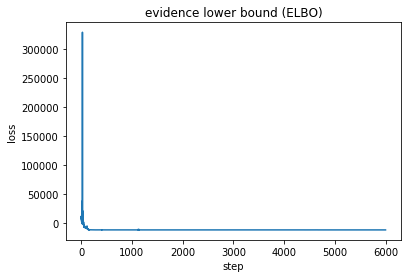

In [104]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Rprop({"lr": learning_rate, "etas": (0.6, 1.5), "step_sizes": (1e-6, 50)})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

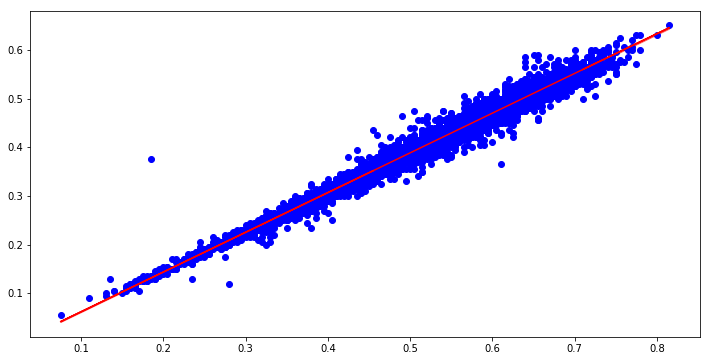

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

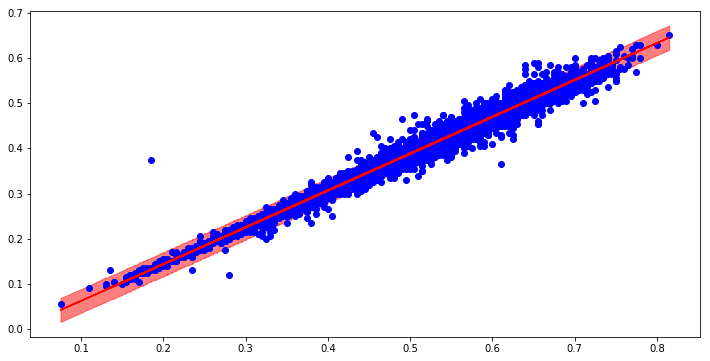

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-2.3695,  0.0979,  0.0980,  0.0976], requires_grad=True)
auto_scale tensor([0.8907, 0.5711, 0.7300, 0.3141], grad_fn=<AddBackward0>)
Wall time: 3min 4s


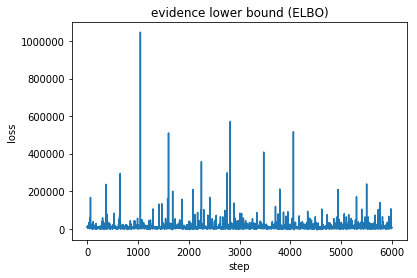

In [107]:
%%time
learning_rate = 0.1
optimizer = pyro.optim.Rprop({"lr": learning_rate, "etas": (0.5, 1.2), "step_sizes": (1e-6, 50)})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

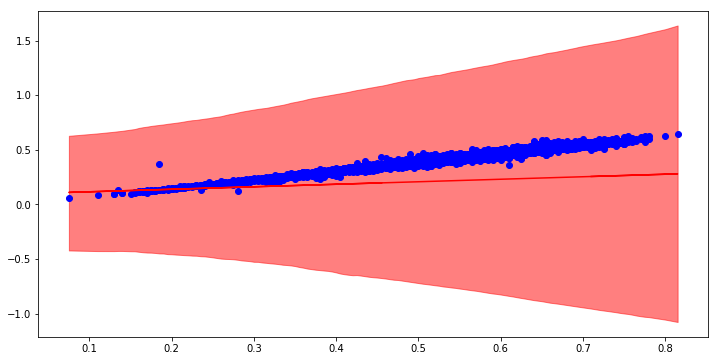

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

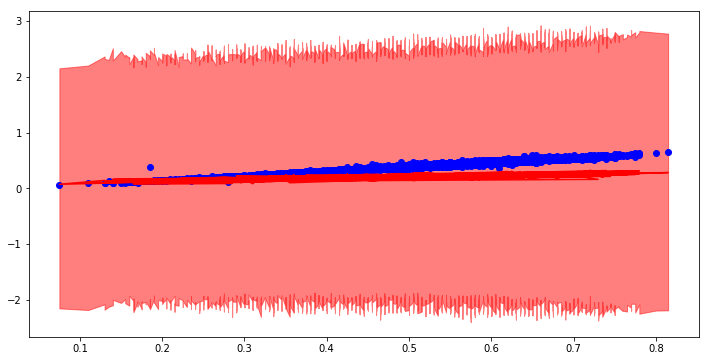

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-2.6851e+00,  1.8421e-03,  5.7154e-03,  1.1498e-03],
       requires_grad=True)
auto_scale tensor([0.9829, 0.9911, 0.9966, 0.9214], grad_fn=<AddBackward0>)
Wall time: 3min 1s


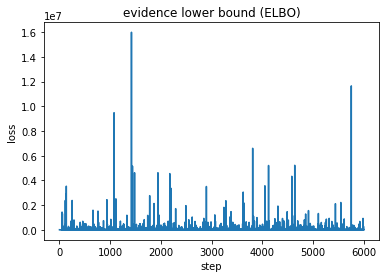

In [110]:
%%time
learning_rate = 0.001
optimizer = pyro.optim.Rprop({"lr": learning_rate, "etas": (0.5, 1.2), "step_sizes": (1e-6, 50)})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

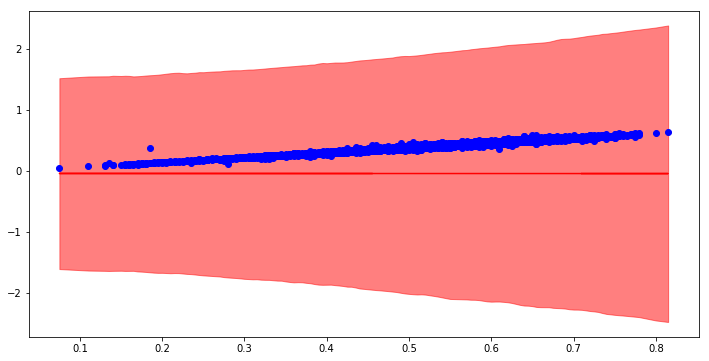

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

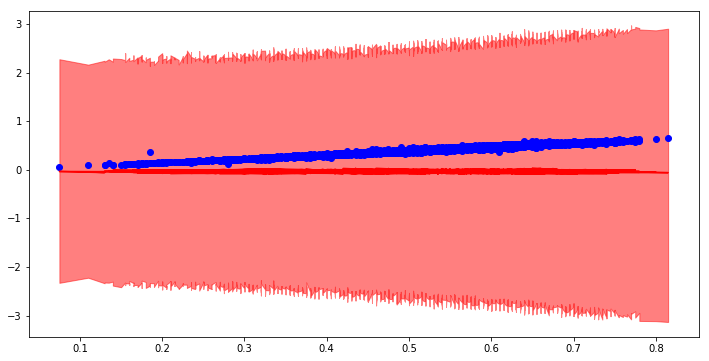

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

## What will happen if you will set extremally low prior distribution parameters (0.000000001, mean, std)

auto_loc tensor([-6.4163,  0.4071,  0.4054, -0.0209], requires_grad=True)
auto_scale tensor([0.0341, 0.0012, 0.0011, 0.0007], grad_fn=<AddBackward0>)
Wall time: 2min 56s


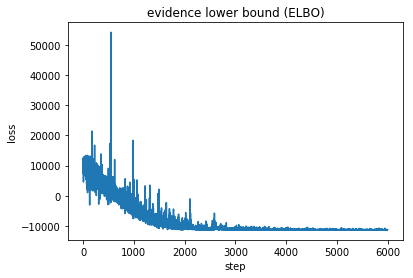

In [113]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*0.000000001, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

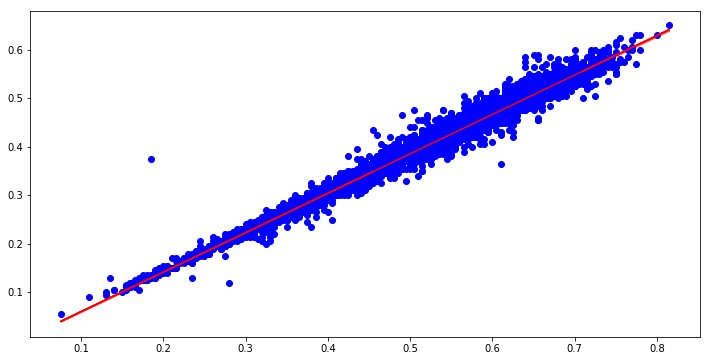

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

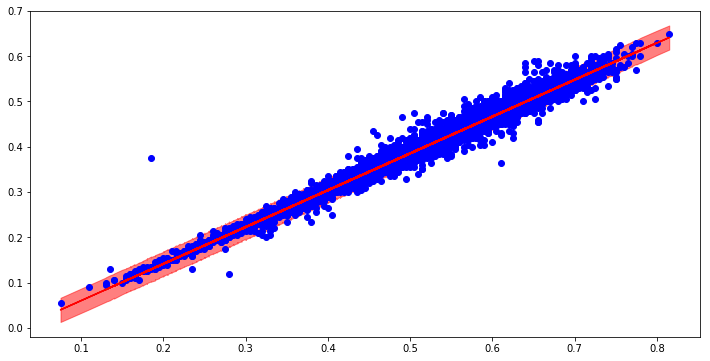

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-6.4025,  0.4082,  0.4062, -0.0196], requires_grad=True)
auto_scale tensor([0.0334, 0.0010, 0.0011, 0.0007], grad_fn=<AddBackward0>)
Wall time: 2min 58s


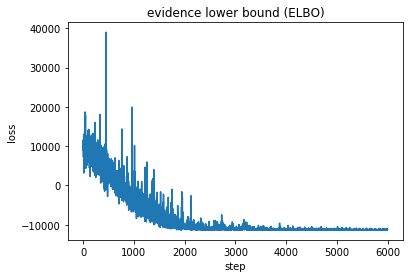

In [116]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*0.0000000000000000000000000000000000001, torch.ones(1, 1)).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

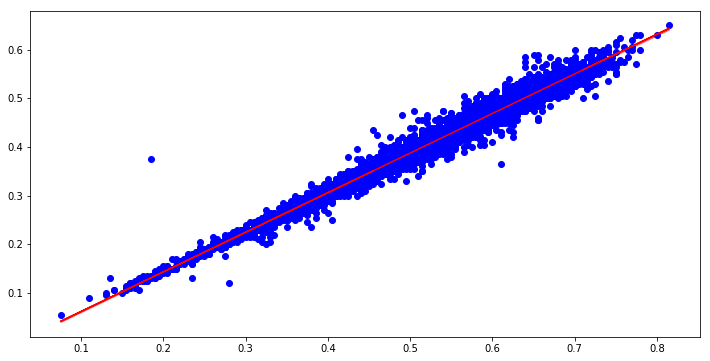

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

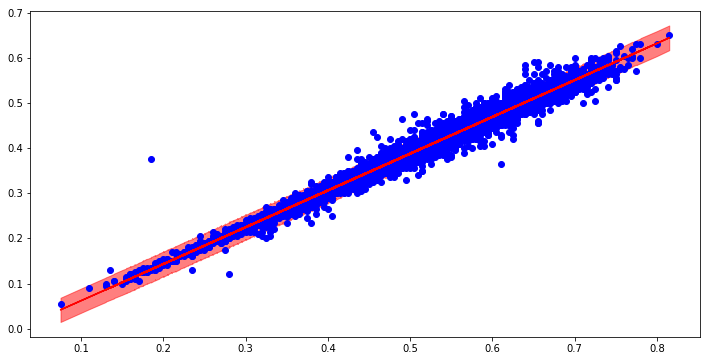

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-5.6812, -2.1908,  3.0071, -0.0267], requires_grad=True)
auto_scale tensor([0.0523, 0.0037, 0.0417, 0.0029], grad_fn=<AddBackward0>)
Wall time: 2min 58s


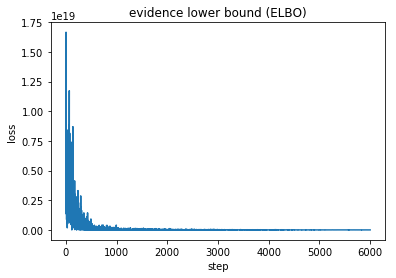

In [119]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*3, torch.ones(1, 1)*0.000000001).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

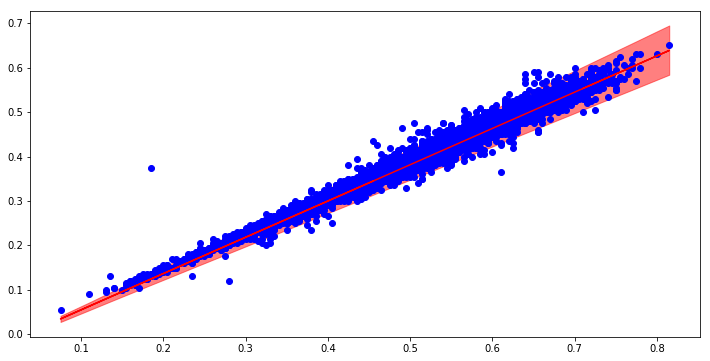

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

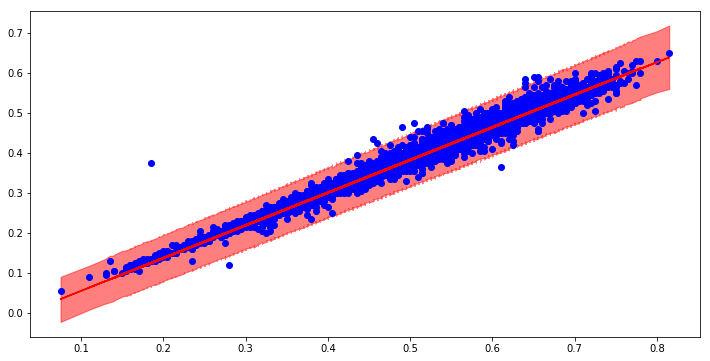

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);

auto_loc tensor([-6.0774e+00,  8.1065e-01, -7.6107e-04, -2.4051e-02],
       requires_grad=True)
auto_scale tensor([0.0540, 0.0022, 0.0233, 0.0015], grad_fn=<AddBackward0>)
Wall time: 3min 3s


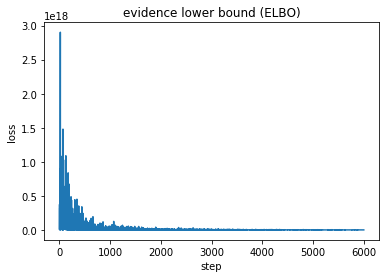

In [122]:
%%time
learning_rate = 0.01
optimizer = pyro.optim.Adam({"lr": learning_rate})

weight_prior = pyro.distributions.Normal(torch.ones(1, 1)*0.000000001, torch.ones(1, 1)*0.000000001).to_event(1)
bias_prior = pyro.distributions.Normal(torch.zeros(1,1), torch.ones(1,1)).to_event(1)
factor_prior = pyro.distributions.Normal(2., 1000.)

losses = []
probabilistic_model, svi = train()

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
posterior = svi.run(x_data, y_data)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=count)
post_pred = trace_pred.run(x_data, None)
post_summary = summary(post_pred, sites= ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": x_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": y_data,
})

plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");

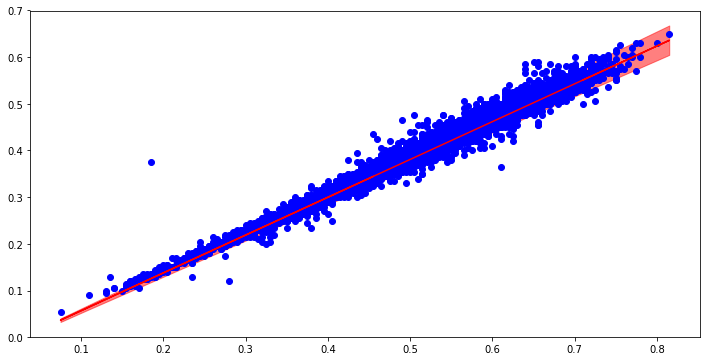

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["mu_perc_5"][aind],
                   predictions["mu_perc_95"][aind],
                   color='r',
                   alpha=0.5);

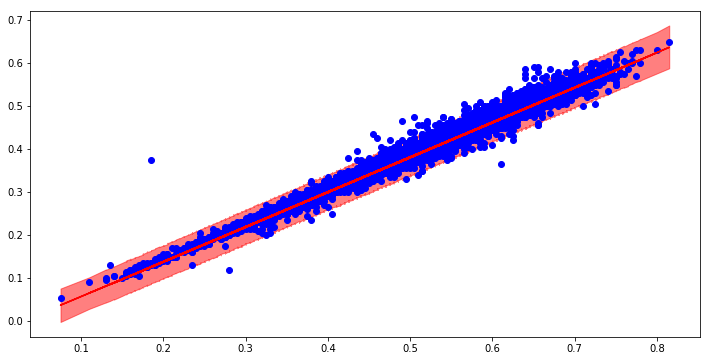

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
x_values=x_data.squeeze().numpy()
plt.plot(x_values, y_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['y_mean'], 'r');
aind = np.argsort(x_values)
plt.fill_between(x_values[aind],
                   predictions["y_perc_5"][aind],
                   predictions["y_perc_95"][aind],
                   color='r',
                   alpha=0.5);